This is the Colab notebook demonstrating our work on reproducing the paper titled: "Text2Mol: Cross-Modal Molecule Retrieval with Natural Language Queries" by Carl Edwards, ChengXiang Zhai, and Heng Ji (see [1]).

- Course: CS598 Deep Learning for Healthcare (Spring 2024)
- Project Team:
  1. Emily Meyer (emilynm4@illinois.edu)
  2. Anna Wysocka (annamw2@illinois.edu)
  3. Jake Kugel (jakugel2@illinois.edu)

- Project Resources:
  1. Notebook: [Link](https://colab.research.google.com/github/jakekugel/uiuc-cs598-text2mol/blob/main/text2mol-project-report.ipynb)
  2. GitHub: [Link](https://github.com/jakekugel/uiuc-cs598-text2mol)
  3. Video on MediaSpace: [Link](https://mediaspace.illinois.edu/media/t/1_oruzbz7k)


# Introduction





## How to run this notebook

All data files required by this notebook are downloaded when the notebook runs, so there is no setup needed before running the notebook.  This notebook has been tested in the Colan environment.  It takes about 9 minutes to run the whole notebook.  To run:

1. Open the notebook in Colab: [Link](https://colab.research.google.com/github/jakekugel/uiuc-cs598-text2mol/blob/main/text2mol-project-report.ipynb).
2. Runtime > Run All.


## Overview

Natural language descriptions of molecules and chemical notations or fingerprints describing the structure of molecules are two very different ways of describing a molecule.  While many existing information retrieval systems for molecular databases rely solely on searching just the natural language descriptions, this approach has limitations because there are many molecules that have a known structure, but for which there has not been laboratory experimentation needed to create the natural language description.  For example, the PubChem database has 110 million chemical compounds of which many do not yet have a natural language description.

Because of the lack of natural language descriptions for many molecules, natural language queries of molecular databases cannot retrieve many chemical compounds because there is no natural language description for them.  This slows progress in areas where discovery of new properties and applications of chemicals is important, such as medicine.

In the paper, "Text2Mol: Cross-Modal Molecule Retrieval with Natural Language Queries" [1], the authors define a new task called Text2Mol which requires the use of a natural language query to retrieve molecules that have a known chemical structure but no natural language description.  In other words, queries in one modality (natural language) are used to retrieve information in another modality (chemical structure).  In this task, the chemical notation is considered a language in itself, which makes the task fall into the category of Cross-Language Information Retrieval (CLIR).

The authors develop a method to accomplish this task by constructing an aligned semantic embedding space for both the natural language embeddings and the chemical notation embeddings.  This means that the molecule's natural language description is mapped to an embedding, and its chemical structure is mapped to an embedding, and the mapping is done in such a way that the resulting embeddings are similar.  Once the aligned space is constructed, a query in either modality can be translated into an embedding in the aligned space and a similarity search used to locate other embeddings in either modality.

For training of the models involved in the task, the authors build a new dataset that contains pairs of molecule descriptions and the corresponding chemical notations.  The dataset, called ChEBI-20, contains 33,010 pairs of molecule natural language descriptions and corresponding chemical notations.  The authors built their dataset from two existing datasets: PubChem (containing chemical notations of molecules), and ChEBI (containing natural language descriptions of molecules).

# Scope of Reproducibility




Our project, documented by this notebook, will test several of the original hypotheses by the authors in the original pager [1].  In addition, we will conduct an ablation study to experimentally test a modified form of one of the hypotheses to extend the knowledge from the original paper.  This section lists the original hypotheses and the new hypothesis to be tested.

The original hypotheses from [1] that will be tested (reproduced) by our project includes the following:

- Hypothesis 1: effective cross-language information retrieval is possible where the two languages are (1) natural text descriptions of molecule properties, and (2) molecular fingerprints.  And an effective method for CLIR in this situation is a shared aligned semantic embedding space.  We will create an aligned semantic embedding space and measure the MRR and Hits@1 performance measurements.
- Hypothesis 2: using an ensemble approach, where multiple embedding spaces are constructed using different methods and then combined is more effective than using a single method and a single embedding space.  We will create an embedding space using different methods, and compare the MRR and Hits@1 performance metrics of the combined space with a single embedding space.

Additionally, we plan to extend the original study with the following ablation study:

- Hypothesis 3: In the ensemble approach of hypthosis #2 above. increasing the number of MLP or GCN models will moderately increase the MRR of the ensemble approach.  We will create a larger number of embedding spaces than used in the original paper, and compare the performance of this larger ensemble to the ensemble used in the original paper.

# Methodology


To reproduce the original experiments, we use the models provided in the GitHub repository created by the paper's authors.  In addition, we will also use the data provided by the authors in the GitHub.  Further details about the models and data are in the respective sections below.

In addition to reproducing the original paper's experiments, we will also extend the paper by performing an ablation study.  Our methodology is to use the original models provided by the authors, but modify them as needed for our planned ablation studies.  More details are in the 'Model' section below.

##Environment

The python version used during the duration of this project is Python 3.10.12. The original GitHub files specify using PyTorch 1.8.0 and CUDA 10.1, but we have modified it to use the pre-installed version on Colab to reduce the installation time for packages, previously it took 40+ minutes and now it runs in under a minute.

In [1]:
# import  packages you need
import torch

#install using local version to speed up install time
!pip install torch-geometric \
  torch-sparse \
  torch-scatter \
  -f https://pytorch-geometric.com/whl/torch-{torch.__version__}.html

!pip install transformers

import os
import os.path as osp
import shutil
import time

import math
import numpy as np

import csv
import random

import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torch_geometric.data import download_url, Data
from torch_geometric.data import Dataset as GeoDataset
from torch_geometric.data import DataLoader as GeoDataLoader
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

import tokenizers
from tokenizers import Tokenizer
from transformers import BertTokenizerFast, BertModel

import zipfile
import pickle

Looking in links: https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 31.9 MB/s eta 0:00:00


##  Data


The data used to perform the experiments in the research paper [1] is stored in GitHub (https://github.com/cnedwards/text2mol/tree/master/data). The dataset was created using PubChem and Chemical Entities of Biological Interest (ChEBI). PubChem is used to collect ChEBI annotation of compounds. The original dataset is composed of 102,980 compound-description pairs. These compounds are used to create dataset ChEBI, with 33,101 pairs. The dataset is split is into 80%, 10%, 10%  which is train, validation, and test respectively. The data containing cid, mol2vec embedding, and description is stored in the "training.txt", "val.txt", and "test.txt" files at the link provided. Additionally, mol_graphs.zip contains the edgelist and tokens, "ChEBI_defintions_substructure_corpus.cp" formats the tokens as sentences, and "token_embedding_dict.npy" contains the embeddings.

In order to run the notebook, it is necessary to have the required files within the working directory. We utilized some of original paper's authors' files which can be downloaded from GitHub (https://github.com/cnedwards/text2mol). Additionally, we have saved pre-trained models for MLP and GCN, as well as, the embeddings for 4 GCN models and 4 MLP models. All required files to run this notebook have been saved in a public zipfile, which is downloaded and extracted using gdown.

In [2]:
# This cell downloads data needed for this notebook, and stores it in the runtime's local folder, /content.
# It is safe to run this cell more than once, the download and unzip will be skipped after the initial run.
import gdown
import os

def download(id, zip_name, folder_name):
    """
    Downloads and unzips a zip file (must be shared as public) from Google Drive.
    If the zip was already downloaded, the download and unzip will be skipped.

    Parameters:
    id (str): The ID of the file to download.  This can be found in the URL of the file.
    zip_name (str): The name and path of the zip file to download.
    folder_name (str): The name of the folder to extract the zip file to. If the folder does not exist, it will be created.

    Returns:
    None
    """
    if os.path.exists(folder_name):
        print(f'The archive {zip_name} has already been downloaded and extracted to {folder_name}, skipping.')
    else:
        gdown.download(id=id, output=zip_name)
        !unzip $zip_name -d $folder_name
        os.remove(zip_name)
        print('Download and unzip complete!')

download('1rezM24hhHwMoRWIushQ28po7PoYbw6Er', "/content/text2mol.zip", "/content/text2mol")

Downloading...
From (original): https://drive.google.com/uc?id=1rezM24hhHwMoRWIushQ28po7PoYbw6Er
From (redirected): https://drive.google.com/uc?id=1rezM24hhHwMoRWIushQ28po7PoYbw6Er&confirm=t&uuid=e5ad06dd-b953-431d-8fc3-72a93c2d79cd
To: /content/text2mol.zip
100%|██████████| 1.87G/1.87G [00:20<00:00, 89.4MB/s]


Streaming output truncated to the last 5000 lines.
  inflating: /content/text2mol/graph-data/raw/91858170.graph  
  inflating: /content/text2mol/graph-data/raw/91858171.graph  
  inflating: /content/text2mol/graph-data/raw/91858178.graph  
  inflating: /content/text2mol/graph-data/raw/91858184.graph  
  inflating: /content/text2mol/graph-data/raw/91858190.graph  
  inflating: /content/text2mol/graph-data/raw/91858192.graph  
  inflating: /content/text2mol/graph-data/raw/91858201.graph  
  inflating: /content/text2mol/graph-data/raw/91858205.graph  
  inflating: /content/text2mol/graph-data/raw/91858207.graph  
  inflating: /content/text2mol/graph-data/raw/91858209.graph  
  inflating: /content/text2mol/graph-data/raw/91858213.graph  
  inflating: /content/text2mol/graph-data/raw/91858217.graph  
  inflating: /content/text2mol/graph-data/raw/91858218.graph  
  inflating: /content/text2mol/graph-data/raw/91858220.graph  
  inflating: /content/text2mol/graph-data/raw/91858226.graph  
  in

In [3]:
os.chdir('/content/text2mol')

The original paper contains two models; Multilayer Perceptron (MLP) and Graph Convolutional Network (GCN). Data preprocessing for this project is largely similar between the two models, with some key differences. Both models use the custom classes GenerateData and Dataset. While only the GCN model uses the MolecularGraphDataset and CustomGraphCollator classes.



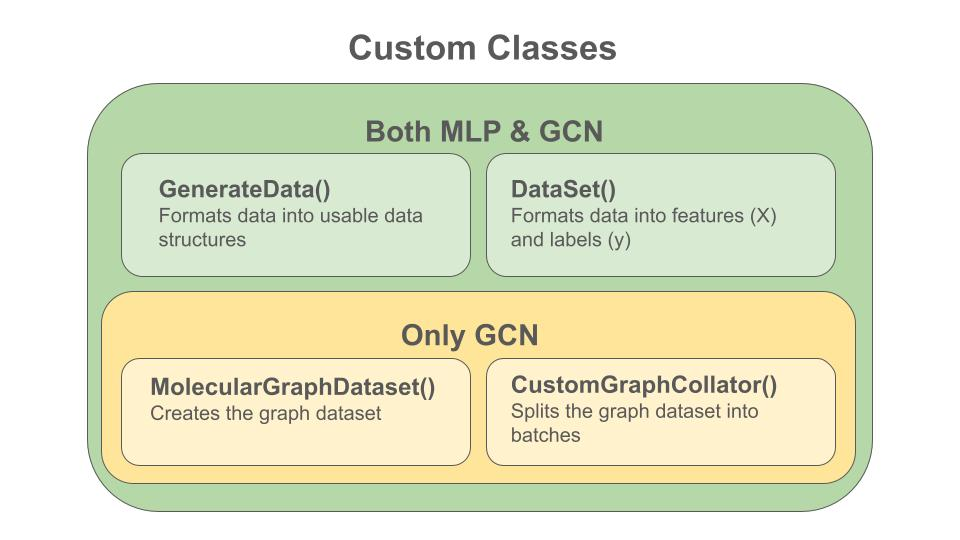

In [5]:
import cv2
from google.colab.patches import cv2_imshow

img1_dir = '/content/text2mol/Final_Project_Images/CustomClasses.jpg'
img1 = cv2.imread(img1_dir)
cv2_imshow(img1)

The GenerateData class accepts five path arguments which are each to a file in the "data" folder within the "text2mol" folder. Data from the files in these paths are saved in three lists, one each for training, validation, and test, and two dictionaries for the mol2vec and description data. Additionally, the three functions: generate_examples_train(), generate_examples_val(), and generate_examples_test() are defined. These functions randomize the order of the list of cids, call the text_tokenizer() function defined using a pre-trained Bert Tokenizer, and yield tokenized text input and the mol2vec molecule for each cid. This class is called and saved as gt, which is used to access the created data structures in the model and training sections of this notebook.

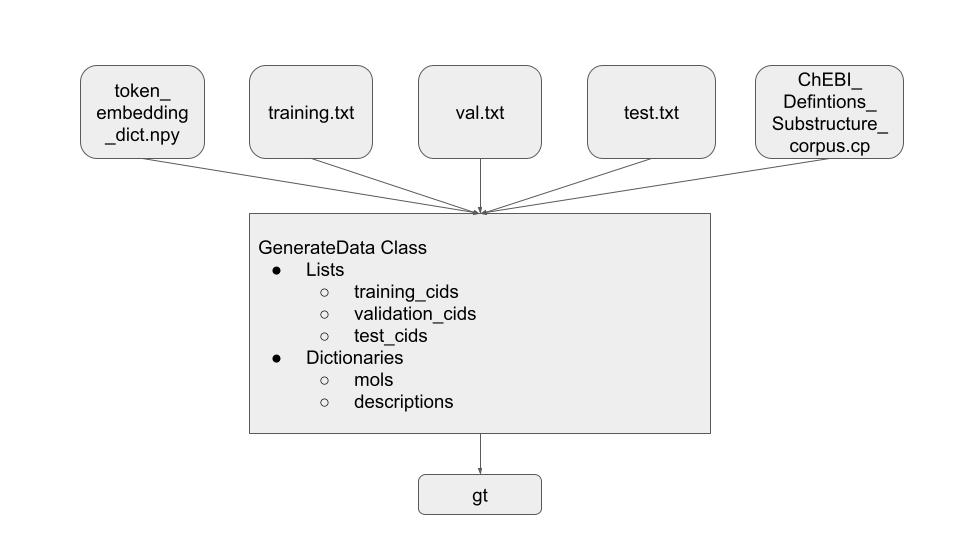

In [7]:
img2_dir = '/content/text2mol/Final_Project_Images/GenerateDataClass.jpg'
img2 = cv2.imread(img2_dir)
cv2_imshow(img2)

The Dataset class takes two arguments, gen and length, and returns a tuple of X and y. When this class is called gen is gt.generate_examples_[x], where [x] is either train, val, or test and length is the number of cids in each list respectively. The output from the Dataset class is the input to the DataLoaders which are saved as training_generator, validation_generator, and test_generator.

The MolecularGraphDataset class is based on GeoDataset, which is the renamed class Dataset from torch_geometric.data. This class enables the creation of graph datasets. Four arguments are used when calling this function; root, cids, data_path, and gt. Root is the path to the folder where the .graph files will be stored. Cids is the list of cids for either train, val, or test datasets. Data_path is the path to where the raw data files are stored. Gt is the instance of the GenerateData class used to hold data structures.

The CustomGraphCollator class takes an object as its argument. The code calling the class shows the object as an instance of the MolecularGraphDataset class. It creates the batches that are used in training the model.

The final cell calls the MolecularGraphDataset and CustomGraphCollator which creates the class objects required to run the GCN model.

In [8]:
#MLP & GCN Code

#Need a special generator for random sampling:
class GenerateData():
  def __init__(self, path_train, path_val, path_test, path_molecules, path_token_embs):
    self.path_train = path_train
    self.path_val = path_val
    self.path_test = path_test
    self.path_molecules = path_molecules
    self.path_token_embs = path_token_embs

    self.text_trunc_length = 256

    self.prep_text_tokenizer()

    self.load_substructures()

    self.batch_size = 32

    self.store_descriptions()

  def load_substructures(self):
    self.molecule_sentences = {}
    self.molecule_tokens = {}

    total_tokens = set()
    self.max_mol_length = 0
    with open(self.path_molecules) as f:
      for line in f:
        spl = line.split(":")
        cid = spl[0]
        tokens = spl[1].strip()
        self.molecule_sentences[cid] = tokens
        t = tokens.split()
        total_tokens.update(t)
        size = len(t)
        if size > self.max_mol_length: self.max_mol_length = size


    self.token_embs = np.load(self.path_token_embs, allow_pickle = True)[()]



  def prep_text_tokenizer(self):
    self.text_tokenizer = BertTokenizerFast.from_pretrained("allenai/scibert_scivocab_uncased")


  def store_descriptions(self):
    self.descriptions = {}

    self.mols = {}

    self.training_cids = []
    #get training set cids...
    with open(self.path_train) as f:
      reader = csv.DictReader(f, delimiter="\t", quoting=csv.QUOTE_NONE, fieldnames = ['cid', 'mol2vec', 'desc'])
      for n, line in enumerate(reader):
        self.descriptions[line['cid']] = line['desc']
        self.mols[line['cid']] = line['mol2vec']
        self.training_cids.append(line['cid'])

    self.validation_cids = []
    #get validation set cids...
    with open(self.path_val) as f:
      reader = csv.DictReader(f, delimiter="\t", quoting=csv.QUOTE_NONE, fieldnames = ['cid', 'mol2vec', 'desc'])
      for n, line in enumerate(reader):
        self.descriptions[line['cid']] = line['desc']
        self.mols[line['cid']] = line['mol2vec']
        self.validation_cids.append(line['cid'])

    self.test_cids = []
    #get test set cids...
    with open(self.path_test) as f:
      reader = csv.DictReader(f, delimiter="\t", quoting=csv.QUOTE_NONE, fieldnames = ['cid', 'mol2vec', 'desc'])
      for n, line in enumerate(reader):
        self.descriptions[line['cid']] = line['desc']
        self.mols[line['cid']] = line['mol2vec']
        self.test_cids.append(line['cid'])

  def generate_examples_train(self):
    """Yields examples."""

    np.random.shuffle(self.training_cids)

    for cid in self.training_cids:
      text_input = self.text_tokenizer(self.descriptions[cid], truncation=True, max_length=self.text_trunc_length,
                                        padding='max_length', return_tensors = 'np')

      yield {
          'cid': cid,
          'input': {
              'text': {
                'input_ids': text_input['input_ids'].squeeze(),
                'attention_mask': text_input['attention_mask'].squeeze(),
              },
              'molecule' : {
                    'mol2vec' : np.fromstring(self.mols[cid], sep = " "),
                    'cid' : cid
              },
          },
      }


  def generate_examples_val(self):
    """Yields examples."""

    np.random.shuffle(self.validation_cids)

    for cid in self.validation_cids:
        text_input = self.text_tokenizer(self.descriptions[cid], truncation=True, padding = 'max_length',
                                         max_length=self.text_trunc_length, return_tensors = 'np')

        mol_input = []

        yield {
            'cid': cid,
            'input': {
                'text': {
                  'input_ids': text_input['input_ids'].squeeze(),
                  'attention_mask': text_input['attention_mask'].squeeze(),
                },
                'molecule' : {
                    'mol2vec' : np.fromstring(self.mols[cid], sep = " "),
                    'cid' : cid
                }
            },
        }


  def generate_examples_test(self):
    """Yields examples."""

    np.random.shuffle(self.test_cids)

    for cid in self.test_cids:
        text_input = self.text_tokenizer(self.descriptions[cid], truncation=True, padding = 'max_length',
                                         max_length=self.text_trunc_length, return_tensors = 'np')

        mol_input = []

        yield {
            'cid': cid,
            'input': {
                'text': {
                  'input_ids': text_input['input_ids'].squeeze(),
                  'attention_mask': text_input['attention_mask'].squeeze(),
                },
                'molecule' : {
                    'mol2vec' : np.fromstring(self.mols[cid], sep = " "),
                    'cid' : cid
                }
            },
        }


# These paths have been updated to work with the current structure of the imported text2mol github folder.
mounted_path_token_embs = "data/token_embedding_dict.npy"
mounted_path_train = "data/training.txt"
mounted_path_val = "data/val.txt"
mounted_path_test = "data/test.txt"
mounted_path_molecules = "data/ChEBI_defintions_substructure_corpus.cp"
gt = GenerateData(mounted_path_train, mounted_path_val, mounted_path_test, mounted_path_molecules, mounted_path_token_embs)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

In [9]:
#MLP & GCN Code
class Dataset(Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, gen, length):
      'Initialization'

      self.gen = gen
      self.it = iter(self.gen())

      self.length = length

  def __len__(self):
      'Denotes the total number of samples'
      return self.length


  def __getitem__(self, index):
      'Generates one sample of data'

      try:
        ex = next(self.it)
      except StopIteration:
        self.it = iter(self.gen())
        ex = next(self.it)

      X = ex['input']
      y = 1

      return X, y

training_set = Dataset(gt.generate_examples_train, len(gt.training_cids))
validation_set = Dataset(gt.generate_examples_val, len(gt.validation_cids))
test_set = Dataset(gt.generate_examples_test, len(gt.test_cids))

In [10]:
#MLP & GCN Code
# Parameters
params = {'batch_size': gt.batch_size,
          'shuffle': True,
          'num_workers': 1}

training_generator = DataLoader(training_set, **params)
validation_generator = DataLoader(validation_set, **params)
test_generator = DataLoader(test_set, **params)

In [11]:
#Only GCN Code
class MoleculeGraphDataset(GeoDataset):
    def __init__(self, root, cids, data_path, gt, transform=None, pre_transform=None):
        self.cids = cids
        self.data_path = data_path
        self.gt = gt
        super(MoleculeGraphDataset, self).__init__(root, transform, pre_transform)

        self.idx_to_cid = {}
        i = 0
        for raw_path in self.raw_paths:
            cid = int(raw_path.split('/')[-1][:-6])
            self.idx_to_cid[i] = cid
            i += 1

    @property
    def raw_file_names(self):
        return [cid + ".graph" for cid in self.cids]

    @property
    def processed_file_names(self):
        return ['data_{}.pt'.format(cid) for cid in self.cids]

    def download(self):
        # Download to `self.raw_dir`.
        shutil.copy(self.data_path, os.path.join(self.raw_dir, "/mol_graphs.zip"))

    def process_graph(self, raw_path):
      edge_index  = []
      x = []
      with open(raw_path, 'r') as f:
        next(f)
        for line in f: #edges
          if line != "\n":
            edge = *map(int, line.split()),
            edge_index.append(edge)
          else:
            break
        next(f)
        for line in f: #get mol2vec features:
          substruct_id = line.strip().split()[-1]
          if substruct_id in self.gt.token_embs:
            x.append(self.gt.token_embs[substruct_id])
          else:
            x.append(self.gt.token_embs['UNK'])

        return torch.LongTensor(edge_index).T, torch.FloatTensor(x)



    def process(self):

        with zipfile.ZipFile(os.path.join(self.raw_dir, "/mol_graphs.zip"), 'r') as zip_ref:
            zip_ref.extractall(self.raw_dir)


        i = 0
        for raw_path in self.raw_paths:
            # Read data from `raw_path`.

            cid = int(raw_path.split('/')[-1][:-6])

            edge_index, x = self.process_graph(raw_path)
            data = Data(x=x, edge_index = edge_index)

            if self.pre_filter is not None and not self.pre_filter(data):
                continue

            if self.pre_transform is not None:
                data = self.pre_transform(data)

            torch.save(data, osp.join(self.processed_dir, 'data_{}.pt'.format(cid)))
            i += 1

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, 'data_{}.pt'.format(self.idx_to_cid[idx])))
        return data

    def get_cid(self, cid):
        data = torch.load(osp.join(self.processed_dir, 'data_{}.pt'.format(cid)))
        return data

#To get specific lists...

class CustomGraphCollater(object):
    def __init__(self, dataset, follow_batch = [], exclude_keys = []):
        self.follow_batch = follow_batch
        self.exclude_keys = exclude_keys
        self.dataset = dataset

    def collate(self, batch):
        elem = batch[0]
        if isinstance(elem, Data):
            return Batch.from_data_list(batch)

        raise TypeError('DataLoader found invalid type: {}'.format(type(elem)))

    def __call__(self, cids):
        return self.collate([self.dataset.get_cid(int(cid)) for cid in cids])



In [12]:
#Removes graph-data folder from the directory

shutil.rmtree('/content/text2mol/graph-data/')

In [13]:
#Only GCN Code
#1 hour execution using drive.mount and CPU
#2 minute excution using gdown method and GPU
#Please ensure that the graph-data is removed from the directory before starting this cell
root = '/content/text2mol/graph-data/'
graph_data_path = "/content/text2mol/data/mol_graphs.zip"


mg_data_tr = MoleculeGraphDataset(root, gt.training_cids, graph_data_path, gt)
graph_batcher_tr = CustomGraphCollater(mg_data_tr)

mg_data_val = MoleculeGraphDataset(root, gt.validation_cids, graph_data_path, gt)
graph_batcher_val = CustomGraphCollater(mg_data_val)

mg_data_test = MoleculeGraphDataset(root, gt.test_cids, graph_data_path, gt)
graph_batcher_test = CustomGraphCollater(mg_data_test)


Processing...
<ipython-input-11-bafa7b5b25a1>:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return torch.LongTensor(edge_index).T, torch.FloatTensor(x)
<ipython-input-11-bafa7b5b25a1>:47: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  return torch.LongTensor(edge_index).T, torch.FloatTensor(x)
Done!
Processing...
Done!
Processing...
Done!


##   Model


This section covers the model definition for both the MLP and GCN models which can be reviewed in the subsections below. Two models are defined in the research paper [1]; a multi-layer perceptron (MLP) and a graph convolutional network (GCN). Each model uses Mol2Vec to link molecule graph structures and their description. The MLP model does this by using the Mol2vec embedding as input and the GCN model does this by integrating Mol2vec into the graph node representations.



### MLP

In the paper, the MLP model is defined as "a two-layer MLP followed by a linear projection and layer normalization to create a trainable representation from the Mol2vec embedding, followed by layer normalization." [1] For the MLP model defined in this section, the model architecture consists of 4 Linear Layers of variable size, two activation functions (ReLU and SELU) and two normalization functions (LayerNorm). The two-layer MLP consists of mol_hidden1 and mol_hidden2, the linear projection is mol_hidden3, and the layer normalization is ln1. In addition to the layers used to calculate x, there is a Linear layer, text_hidden1, that is used for linear projection of text_x and a normalization function, ln2. For the training objectives, Cross Entropy Loss is used as the loss function and optim.Adam is used as the optimizer.



In [14]:
class MLPModel(nn.Module):
    def __init__(self, ntoken, ninp, nout, nhid, dropout=0.5):
        super(MLPModel, self).__init__()


        self.text_hidden1 = nn.Linear(ninp, nout)

        self.ninp = ninp
        self.nhid = nhid
        self.nout = nout

        self.drop = nn.Dropout(p=dropout)

        self.mol_hidden1 = nn.Linear(nout, nhid)
        self.mol_hidden2 = nn.Linear(nhid, nhid)
        self.mol_hidden3 = nn.Linear(nhid, nout)


        self.temp = nn.Parameter(torch.Tensor([0.07]))
        self.register_parameter( 'temp' , self.temp )

        self.ln1 = nn.LayerNorm((nout))
        self.ln2 = nn.LayerNorm((nout))

        self.relu = nn.ReLU()
        self.selu = nn.SELU()

        self.other_params = list(self.parameters()) #get all but bert params

        self.text_transformer_model = BertModel.from_pretrained('allenai/scibert_scivocab_uncased')
        self.text_transformer_model.train()

    def forward(self, text, molecule, text_mask = None, molecule_mask = None):

        text_encoder_output = self.text_transformer_model(text, attention_mask = text_mask)

        text_x = text_encoder_output['pooler_output']
        text_x = self.text_hidden1(text_x)

        x = self.relu(self.mol_hidden1(molecule))
        x = self.relu(self.mol_hidden2(x))
        x = self.mol_hidden3(x)


        x = self.ln1(x)
        text_x = self.ln2(text_x)

        x = x * torch.exp(self.temp)
        text_x = text_x * torch.exp(self.temp)

        return text_x, x


In [15]:
MLPModel_Var = MLPModel(ntoken = gt.text_tokenizer.vocab_size, ninp = 768, nhid = 600, nout = 300)

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

In [16]:
import torch.optim as optim
from transformers.optimization import get_linear_schedule_with_warmup

epochs = 1 #Number of epochs has been reduced for this notebook. Fully trained models are available in the Training section.

init_lr = 1e-4
bert_lr = 3e-5
bert_params = list(MLPModel_Var.text_transformer_model.parameters())

optimizer = optim.Adam([
                {'params': MLPModel_Var.other_params},
                {'params': bert_params, 'lr': bert_lr}
            ], lr=init_lr)

num_warmup_steps = 1000
num_training_steps = epochs * len(training_generator) - num_warmup_steps
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = num_warmup_steps, num_training_steps = num_training_steps)

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

tmp = MLPModel_Var.to(device)

cuda:0


In [18]:
criterion = nn.CrossEntropyLoss()

def loss_func(v1, v2):
  logits = torch.matmul(v1,torch.transpose(v2, 0, 1))
  labels = torch.arange(logits.shape[0]).to(device)
  return criterion(logits, labels) + criterion(torch.transpose(logits, 0, 1), labels)

### GCN

The paper describes the GCN model as a three-layer model with Mol2vec token features as input, creating a node to represent each atom in the molecule [1]. Then, a molecule representation is made by using global mean pooling to combine the node representations and passing that through two additional hidden layers. In the GCNModel class defined below, the model architecture consists of 7 layers in total: 3 GCNConv layers and 4 Linear Layers each of variable size, two activation functions (ReLU and SELU) and two normalization functions (LayerNorm). The GCN convolutions used to obtain the node embeddings are conv1, conv2, and conv3 with the ReLU activation function run after conv1 and conv2. Then, global_mean_pool is run. Finally, mol_hidden1 and mol_hidden2 are run as hidden layers with the ReLU function after each before mol_hidden3 is run as a linear projection. Finally, ln1, is run as the layer normalization function. Similar to the MLPModel class, there is a Linear layer, text_hidden1, that is used for linear projection of text_x and a normalization function, ln2. For the training objectives, Cross Entropy Loss is used as the loss function and optim.Adam is used as the optimizer.

In [19]:
class GCNModel(nn.Module):
    def __init__(self, ntoken, ninp, nout, nhid, graph_hidden_channels, dropout=0.5):
        super(GCNModel, self).__init__()


        self.text_hidden1 = nn.Linear(ninp, nout)

        self.ninp = ninp
        self.nhid = nhid
        self.nout = nout

        self.drop = nn.Dropout(p=dropout)

        self.temp = nn.Parameter(torch.Tensor([0.07]))
        self.register_parameter( 'temp' , self.temp )

        self.ln1 = nn.LayerNorm((nout))
        self.ln2 = nn.LayerNorm((nout))

        self.relu = nn.ReLU()
        self.selu = nn.SELU()

        #For GCN:
        self.conv1 = GCNConv(mg_data_val.num_node_features, graph_hidden_channels)
        self.conv2 = GCNConv(graph_hidden_channels, graph_hidden_channels)
        self.conv3 = GCNConv(graph_hidden_channels, graph_hidden_channels)
        self.mol_hidden1 = nn.Linear(graph_hidden_channels, nhid)
        self.mol_hidden2 = nn.Linear(nhid, nhid)
        self.mol_hidden3 = nn.Linear(nhid, nout)


        self.other_params = list(self.parameters()) #get all but bert params

        self.text_transformer_model = BertModel.from_pretrained('allenai/scibert_scivocab_uncased')
        self.text_transformer_model.train()

    def forward(self, text, graph_batch, text_mask = None, molecule_mask = None):

        text_encoder_output = self.text_transformer_model(text, attention_mask = text_mask)

        text_x = text_encoder_output['pooler_output']
        text_x = self.text_hidden1(text_x)


        #Obtain node embeddings
        x = graph_batch.x
        edge_index = graph_batch.edge_index
        batch = graph_batch.batch
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, graph_hidden_channels]


        x = self.mol_hidden1(x).relu()
        x = self.mol_hidden2(x).relu()
        x = self.mol_hidden3(x)


        x = self.ln1(x)
        text_x = self.ln2(text_x)

        x = x * torch.exp(self.temp)
        text_x = text_x * torch.exp(self.temp)

        return text_x, x


In [20]:
GCNModel_Var = GCNModel(ntoken = gt.text_tokenizer.vocab_size, ninp = 768, nhid = 600, nout = 300, graph_hidden_channels = 600)

In [21]:
import torch.optim as optim
from transformers.optimization import get_linear_schedule_with_warmup

epochs = 1 #Number of epochs has been reduced for this notebook. Fully trained models are available in the Training section.

init_lr = 1e-4
bert_lr = 3e-5
bert_params = list(GCNModel_Var.text_transformer_model.parameters())

optimizer = optim.Adam([
                {'params': GCNModel_Var.other_params},
                {'params': bert_params, 'lr': bert_lr}
            ], lr=init_lr)

num_warmup_steps = 1000
num_training_steps = epochs * len(training_generator) - num_warmup_steps
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = num_warmup_steps, num_training_steps = num_training_steps)

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

tmp = GCNModel_Var.to(device)

cuda:0


In [23]:
criterion = nn.CrossEntropyLoss()

def loss_func(v1, v2):
  logits = torch.matmul(v1,torch.transpose(v2, 0, 1))
  labels = torch.arange(logits.shape[0]).to(device)
  return criterion(logits, labels) + criterion(torch.transpose(logits, 0, 1), labels)


## Training

This section covers the training for both the MLP and GCN models which can be reviewed in the subsections below.

**Hyperparameters:** There are various hyperparameters used to run the models saved throughout the code. The first hyperparameters are saved within the gt class object created by calling the GenerateData class. The batch size is set as 32 during this step. Within each model, the hidden size is named nhid. Nhid is set to 600 when both the MLPModel class and GCNModel class are called. Dropout is set to 0.5 in each model. Following the model definitions, there are two learning rates that are set for the models. The first is init_lr, which is set to 1e-4. The second is bert_lr, which is set to 3e5.

**Computational requirements:**
During the course of this project our team utilized a combination of Colab Pro, Google Cloud VM, and MacBook to run the code and complete the training. The average runtime for each epoch was 20 minutes. For the purpose of this notebook the number of epochs has been reduced to 1, but the fully trained model consists of 40 epochs. Each model has a pre-trained version that can be loaded at the end of its subsection. Each model was fully trained 4 times for use in the all ensemble method. Our team required 100 total GPU hours to complete this project.

### MLP

This code covers the training process for the MLP model. The first cell of code is set for 1 epoch and can be uncommented and run to verify that the code is functional. Due to the length of training time the model has been pretrained outside of this notebook, the following cell will load the pre-trained MLP model.

In [24]:
# The time required to run through of this code block with 1 epoch is 19m 23s using T4 in Colab.
# With 40 epochs it is approximately 4 hours using Colab Pro.
'''
train_losses = []
val_losses = []

train_acc = []
val_acc = []

mounted_path = "MLP_outputs/"
if not os.path.exists(mounted_path):
  os.mkdir(mounted_path)

# Loop over epochs
for epoch in range(epochs):
    # Training

    start_time = time.time()
    running_loss = 0.0
    running_acc = 0.0
    MLPModel_Var.train()
    for i, d in enumerate(training_generator):
        batch, labels = d
        # Transfer to GPU

        text_mask = batch['text']['attention_mask'].bool()

        text = batch['text']['input_ids'].to(device)
        text_mask = text_mask.to(device)
        molecule = batch['molecule']['mol2vec'].float().to(device)

        text_out, chem_out = MLPModel_Var(text, molecule, text_mask)

        loss = loss_func(text_out, chem_out).to(device)

        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        scheduler.step()

        if (i+1) % 100 == 0: print(i+1, "batches trained. Avg loss:\t", running_loss / (i+1), ". Avg ms/step =", 1000*(time.time()-start_time)/(i+1))
    train_losses.append(running_loss / (i+1))
    train_acc.append(running_acc / (i+1))

    print("Epoch", epoch, "training loss:\t\t", running_loss / (i+1), ". Time =", (time.time()-start_time), "seconds.")



    # Validation
    MLPModel_Var.eval()
    with torch.set_grad_enabled(False):
      start_time = time.time()
      running_acc = 0.0
      running_loss = 0.0
      for i, d in enumerate(validation_generator):
          batch, labels = d
          # Transfer to GPU

          text_mask = batch['text']['attention_mask'].bool()

          text = batch['text']['input_ids'].to(device)
          text_mask = text_mask.to(device)
          molecule = batch['molecule']['mol2vec'].float().to(device)



          text_out, chem_out = MLPModel_Var(text, molecule, text_mask)

          loss = loss_func(text_out, chem_out).to(device)
          running_loss += loss.item()

          if (i+1) % 100 == 0: print(i+1, "batches eval. Avg loss:\t", running_loss / (i+1), ". Avg ms/step =", 1000*(time.time()-start_time)/(i+1))
      val_losses.append(running_loss / (i+1))
      val_acc.append(running_acc / (i+1))


      min_loss = np.min(val_losses)
      if val_losses[-1] == min_loss:
          torch.save(MLPModel_Var.state_dict(), mounted_path + 'weights_pretrained.{epoch:02d}-{min_loss:.2f}.pt'.format(epoch = epoch, min_loss = min_loss))

    print("Epoch", epoch, "validation loss:\t", running_loss / (i+1), ". Time =", (time.time()-start_time), "seconds.")


torch.save(MLPModel_Var.state_dict(), mounted_path + "final_weights."+str(epochs)+".pt")
'''

'\ntrain_losses = []\nval_losses = []\n\ntrain_acc = []\nval_acc = []\n\nmounted_path = "MLP_outputs/"\nif not os.path.exists(mounted_path):\n  os.mkdir(mounted_path)\n\n# Loop over epochs\nfor epoch in range(epochs):\n    # Training\n\n    start_time = time.time()\n    running_loss = 0.0\n    running_acc = 0.0\n    MLPModel_Var.train()\n    for i, d in enumerate(training_generator):\n        batch, labels = d\n        # Transfer to GPU\n\n        text_mask = batch[\'text\'][\'attention_mask\'].bool()\n\n        text = batch[\'text\'][\'input_ids\'].to(device)\n        text_mask = text_mask.to(device)\n        molecule = batch[\'molecule\'][\'mol2vec\'].float().to(device)\n\n        text_out, chem_out = MLPModel_Var(text, molecule, text_mask)\n\n        loss = loss_func(text_out, chem_out).to(device)\n\n        running_loss += loss.item()\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n\n        scheduler.step()\n\n        if (i+1) % 100 == 0: print(i

In [25]:
#Code to load the pretrained model
MLPModel_Var.load_state_dict(torch.load("MLP1_output/final_weights.40.pt"))
MLPModel_Var.eval()

MLPModel(
  (text_hidden1): Linear(in_features=768, out_features=300, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (mol_hidden1): Linear(in_features=300, out_features=600, bias=True)
  (mol_hidden2): Linear(in_features=600, out_features=600, bias=True)
  (mol_hidden3): Linear(in_features=600, out_features=300, bias=True)
  (ln1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
  (ln2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
  (relu): ReLU()
  (selu): SELU()
  (text_transformer_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertS

### GCN

This code covers the training process for the GCN model. The first cell of code is set for 1 epoch and can be uncommented and run to verify that the code is functional. Due to the length of training time the model has been pretrained outside of this notebook, the following cell will load the pre-trained model.

In [26]:
# The time required to run through of this code block with 1 epoch is "19m 29s" using T4 in Colab.
# With 40 epochs it is approximately 4 hours using Colab Pro.
#GCN Code
'''
train_losses = []
val_losses = []

train_acc = []
val_acc = []

mounted_path = "GCN_output/"
if not os.path.exists(mounted_path):
  os.makedirs(mounted_path)

# Loop over epochs
for epoch in range(epochs):
    # Training

    start_time = time.time()
    running_loss = 0.0
    running_acc = 0.0
    GCNModel_Var.train()
    for i, d in enumerate(training_generator):
        batch, labels = d
        # Transfer to GPU

        text_mask = batch['text']['attention_mask'].bool()

        text = batch['text']['input_ids'].to(device)
        text_mask = text_mask.to(device)
        graph_batch = graph_batcher_tr(d[0]['molecule']['cid']).to(device)


        text_out, chem_out = GCNModel_Var(text, graph_batch, text_mask)

        loss = loss_func(text_out, chem_out).to(device)

        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        scheduler.step()

        if (i+1) % 100 == 0: print(i+1, "batches trained. Avg loss:\t", running_loss / (i+1), ". Avg ms/step =", 1000*(time.time()-start_time)/(i+1))
    train_losses.append(running_loss / (i+1))
    train_acc.append(running_acc / (i+1))

    print("Epoch", epoch, "training loss:\t\t", running_loss / (i+1), ". Time =", (time.time()-start_time), "seconds.")



    # Validation
    GCNModel_Var.eval()
    with torch.set_grad_enabled(False):
      start_time = time.time()
      running_acc = 0.0
      running_loss = 0.0
      for i, d in enumerate(validation_generator):
          batch, labels = d
          # Transfer to GPU

          text_mask = batch['text']['attention_mask'].bool()

          text = batch['text']['input_ids'].to(device)
          text_mask = text_mask.to(device)
          graph_batch = graph_batcher_val(d[0]['molecule']['cid']).to(device)


          text_out, chem_out = GCNModel_Var(text, graph_batch, text_mask)

          loss = loss_func(text_out, chem_out).to(device)
          running_loss += loss.item()

          if (i+1) % 100 == 0: print(i+1, "batches eval. Avg loss:\t", running_loss / (i+1), ". Avg ms/step =", 1000*(time.time()-start_time)/(i+1))
      val_losses.append(running_loss / (i+1))
      val_acc.append(running_acc / (i+1))


      min_loss = np.min(val_losses)
      if val_losses[-1] == min_loss:
          torch.save(GCNModel_Var.state_dict(), mounted_path + 'weights_pretrained.{epoch:02d}-{min_loss:.2f}.pt'.format(epoch = epoch, min_loss = min_loss))

    print("Epoch", epoch, "validation loss:\t", running_loss / (i+1), ". Time =", (time.time()-start_time), "seconds.")


#Save last accuracy:
torch.save(GCNModel_Var.state_dict(), mounted_path + "final_weights."+str(epochs)+".pt")
'''

'\ntrain_losses = []\nval_losses = []\n\ntrain_acc = []\nval_acc = []\n\nmounted_path = "GCN_output/"\nif not os.path.exists(mounted_path):\n  os.makedirs(mounted_path)\n\n# Loop over epochs\nfor epoch in range(epochs):\n    # Training\n\n    start_time = time.time()\n    running_loss = 0.0\n    running_acc = 0.0\n    GCNModel_Var.train()\n    for i, d in enumerate(training_generator):\n        batch, labels = d\n        # Transfer to GPU\n\n        text_mask = batch[\'text\'][\'attention_mask\'].bool()\n\n        text = batch[\'text\'][\'input_ids\'].to(device)\n        text_mask = text_mask.to(device)\n        graph_batch = graph_batcher_tr(d[0][\'molecule\'][\'cid\']).to(device)\n\n\n        text_out, chem_out = GCNModel_Var(text, graph_batch, text_mask)\n\n        loss = loss_func(text_out, chem_out).to(device)\n\n        running_loss += loss.item()\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n\n        scheduler.step()\n\n        if (i+1) % 10

In [27]:
#Code to load the pretrained model
GCNModel_Var.load_state_dict(torch.load("GCN1_output/final_weights.40.pt"))
GCNModel_Var.eval()

GCNModel(
  (text_hidden1): Linear(in_features=768, out_features=300, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (ln1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
  (ln2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
  (relu): ReLU()
  (selu): SELU()
  (conv1): GCNConv(300, 600)
  (conv2): GCNConv(600, 600)
  (conv3): GCNConv(600, 600)
  (mol_hidden1): Linear(in_features=600, out_features=600, bias=True)
  (mol_hidden2): Linear(in_features=600, out_features=600, bias=True)
  (mol_hidden3): Linear(in_features=600, out_features=300, bias=True)
  (text_transformer_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        

## Evaluation

This evaluation section first describes the metrics used to evaluate the trained models.  Then, this section has working code cells to measure these using the embeddings from a previous construction of the aligned embedding space.

In the interest of time, the code within this notebook only evaluates a single embedding space that was previously constructed using the GCN model for molecular embedding.  At the end of the evaluation section, a table is rendered showing the evaluation metrics for this single embedding space.

Later, in the Results section of this notebook, we show the evaluation results for the full ensemble.


### Metrics Descriptions

Once the embeddings are generated in the aligned embedding space, there are two primary performance metrics used to evaluate the aligned space: MRR and Hits@1.  These metrics are described below.

1. **MRR**: Mean Reciprocal Rank.  Each text embedding is considered in turn, and the chemical embeddings are searched using a cosine similarity search.  The results are ranked by distance from the text embedding, and the rank of the correct ground truth chemical embedding is identified.  The MRR is the average of the reciprocal of all ranks.

2. **Hits@1**: probability that the correct chemical embedding is ranked first.  For each text embedding, this is the probability that the closest chemical embedding found is the correct ground truth chemical embedding.

### Implementation Code

In [28]:
#Not needed?

'''
import os
import shutil

import numpy as np

import matplotlib.pyplot as plt

import math
'''

'\nimport os\nimport shutil\n\nimport numpy as np\n\nimport matplotlib.pyplot as plt\n\nimport math\n'

In [29]:
dir1 = "inputs/GCN1/embeddings/"
dir2 = "inputs/GCN2/embeddings/"
dir3 = "inputs/GCN3/embeddings/"
dir4 = "inputs/MLP1/embeddings/"
dir5 = "inputs/MLP2/embeddings/"
dir6 = "inputs/MLP3/embeddings/"


cids_train1 = np.load(dir1 + "cids_train.npy", allow_pickle=True)
cids_val1 = np.load(dir1 + "cids_val.npy", allow_pickle=True)
cids_test1 = np.load(dir1 + "cids_test.npy", allow_pickle=True)

chem_embeddings_train1 = np.load(dir1 + "chem_embeddings_train.npy")
chem_embeddings_val1 = np.load(dir1 + "chem_embeddings_val.npy")
chem_embeddings_test1 = np.load(dir1 + "chem_embeddings_test.npy")
text_embeddings_train1 = np.load(dir1 + "text_embeddings_train.npy")
text_embeddings_val1 = np.load(dir1 + "text_embeddings_val.npy")
text_embeddings_test1 = np.load(dir1 + "text_embeddings_test.npy")

cids_train2 = np.load(dir2 + "cids_train.npy", allow_pickle=True)
cids_val2 = np.load(dir2 + "cids_val.npy", allow_pickle=True)
cids_test2 = np.load(dir2 + "cids_test.npy", allow_pickle=True)

chem_embeddings_train2 = np.load(dir2 + "chem_embeddings_train.npy")
chem_embeddings_val2 = np.load(dir2 + "chem_embeddings_val.npy")
chem_embeddings_test2 = np.load(dir2 + "chem_embeddings_test.npy")
text_embeddings_train2 = np.load(dir2 + "text_embeddings_train.npy")
text_embeddings_val2 = np.load(dir2 + "text_embeddings_val.npy")
text_embeddings_test2 = np.load(dir2 + "text_embeddings_test.npy")

cids_train3 = np.load(dir3 + "cids_train.npy", allow_pickle=True)
cids_val3 = np.load(dir3 + "cids_val.npy", allow_pickle=True)
cids_test3 = np.load(dir3 + "cids_test.npy", allow_pickle=True)

chem_embeddings_train3 = np.load(dir3 + "chem_embeddings_train.npy")
chem_embeddings_val3 = np.load(dir3 + "chem_embeddings_val.npy")
chem_embeddings_test3 = np.load(dir3 + "chem_embeddings_test.npy")
text_embeddings_train3 = np.load(dir3 + "text_embeddings_train.npy")
text_embeddings_val3 = np.load(dir3 + "text_embeddings_val.npy")
text_embeddings_test3 = np.load(dir3 + "text_embeddings_test.npy")

cids_train4 = np.load(dir4 + "cids_train.npy", allow_pickle=True)
cids_val4 = np.load(dir4 + "cids_val.npy", allow_pickle=True)
cids_test4 = np.load(dir4 + "cids_test.npy", allow_pickle=True)

chem_embeddings_train4 = np.load(dir4 + "chem_embeddings_train.npy")
chem_embeddings_val4 = np.load(dir4 + "chem_embeddings_val.npy")
chem_embeddings_test4 = np.load(dir4 + "chem_embeddings_test.npy")
text_embeddings_train4 = np.load(dir4 + "text_embeddings_train.npy")
text_embeddings_val4 = np.load(dir4 + "text_embeddings_val.npy")
text_embeddings_test4 = np.load(dir4 + "text_embeddings_test.npy")

cids_train5 = np.load(dir5 + "cids_train.npy", allow_pickle=True)
cids_val5 = np.load(dir5 + "cids_val.npy", allow_pickle=True)
cids_test5 = np.load(dir5 + "cids_test.npy", allow_pickle=True)

chem_embeddings_train5 = np.load(dir5 + "chem_embeddings_train.npy")
chem_embeddings_val5 = np.load(dir5 + "chem_embeddings_val.npy")
chem_embeddings_test5 = np.load(dir5 + "chem_embeddings_test.npy")
text_embeddings_train5 = np.load(dir5 + "text_embeddings_train.npy")
text_embeddings_val5 = np.load(dir5 + "text_embeddings_val.npy")
text_embeddings_test5 = np.load(dir5 + "text_embeddings_test.npy")

cids_train6 = np.load(dir6 + "cids_train.npy", allow_pickle=True)
cids_val6 = np.load(dir6 + "cids_val.npy", allow_pickle=True)
cids_test6 = np.load(dir6 + "cids_test.npy", allow_pickle=True)

chem_embeddings_train6 = np.load(dir6 + "chem_embeddings_train.npy")
chem_embeddings_val6 = np.load(dir6 + "chem_embeddings_val.npy")
chem_embeddings_test6 = np.load(dir6 + "chem_embeddings_test.npy")
text_embeddings_train6 = np.load(dir6 + "text_embeddings_train.npy")
text_embeddings_val6 = np.load(dir6 + "text_embeddings_val.npy")
text_embeddings_test6 = np.load(dir6 + "text_embeddings_test.npy")

#Reorder (this is very important):
tmp = cids_train2.tolist()
indexes = [tmp.index(i) for i in cids_train1]
tmp = cids_val2.tolist()
indexes_val = [tmp.index(i) for i in cids_val1]
tmp = cids_test2.tolist()
indexes_test = [tmp.index(i) for i in cids_test1]

cids_train2 = cids_train2[indexes]
cids_val2 = cids_val2[indexes_val]
cids_test2 = cids_test2[indexes_test]

chem_embeddings_train2 = chem_embeddings_train2[indexes]
text_embeddings_train2 = text_embeddings_train2[indexes]
chem_embeddings_val2 = chem_embeddings_val2[indexes_val]
text_embeddings_val2 = text_embeddings_val2[indexes_val]
chem_embeddings_test2 = chem_embeddings_test2[indexes_test]
text_embeddings_test2 = text_embeddings_test2[indexes_test]


tmp = cids_train3.tolist()
indexes = [tmp.index(i) for i in cids_train1]
tmp = cids_val3.tolist()
indexes_val = [tmp.index(i) for i in cids_val1]
tmp = cids_test3.tolist()
indexes_test = [tmp.index(i) for i in cids_test1]

cids_train3 = cids_train3[indexes]
cids_val3 = cids_val3[indexes_val]
cids_test3 = cids_test3[indexes_test]

chem_embeddings_train3 = chem_embeddings_train3[indexes]
text_embeddings_train3 = text_embeddings_train3[indexes]
chem_embeddings_val3 = chem_embeddings_val3[indexes_val]
text_embeddings_val3 = text_embeddings_val3[indexes_val]
chem_embeddings_test3 = chem_embeddings_test3[indexes_test]
text_embeddings_test3 = text_embeddings_test3[indexes_test]


tmp = cids_train4.tolist()
indexes = [tmp.index(i) for i in cids_train1]
tmp = cids_val4.tolist()
indexes_val = [tmp.index(i) for i in cids_val1]
tmp = cids_test4.tolist()
indexes_test = [tmp.index(i) for i in cids_test1]

cids_train4 = cids_train4[indexes]
cids_val4 = cids_val4[indexes_val]
cids_test4 = cids_test4[indexes_test]

chem_embeddings_train4 = chem_embeddings_train4[indexes]
text_embeddings_train4 = text_embeddings_train4[indexes]
chem_embeddings_val4 = chem_embeddings_val4[indexes_val]
text_embeddings_val4 = text_embeddings_val4[indexes_val]
chem_embeddings_test4 = chem_embeddings_test4[indexes_test]
text_embeddings_test4 = text_embeddings_test4[indexes_test]


tmp = cids_train5.tolist()
indexes = [tmp.index(i) for i in cids_train1]
tmp = cids_val5.tolist()
indexes_val = [tmp.index(i) for i in cids_val1]
tmp = cids_test5.tolist()
indexes_test = [tmp.index(i) for i in cids_test1]

cids_train5 = cids_train5[indexes]
cids_val5 = cids_val5[indexes_val]
cids_test5 = cids_test5[indexes_test]

chem_embeddings_train5 = chem_embeddings_train5[indexes]
text_embeddings_train5 = text_embeddings_train5[indexes]
chem_embeddings_val5 = chem_embeddings_val5[indexes_val]
text_embeddings_val5 = text_embeddings_val5[indexes_val]
chem_embeddings_test5 = chem_embeddings_test5[indexes_test]
text_embeddings_test5 = text_embeddings_test5[indexes_test]


tmp = cids_train6.tolist()
indexes = [tmp.index(i) for i in cids_train1]
tmp = cids_val6.tolist()
indexes_val = [tmp.index(i) for i in cids_val1]
tmp = cids_test6.tolist()
indexes_test = [tmp.index(i) for i in cids_test1]

cids_train6 = cids_train6[indexes]
cids_val6 = cids_val6[indexes_val]
cids_test6 = cids_test6[indexes_test]

chem_embeddings_train6 = chem_embeddings_train6[indexes]
text_embeddings_train6 = text_embeddings_train6[indexes]
chem_embeddings_val6 = chem_embeddings_val6[indexes_val]
text_embeddings_val6 = text_embeddings_val6[indexes_val]
chem_embeddings_test6 = chem_embeddings_test6[indexes_test]
text_embeddings_test6 = text_embeddings_test6[indexes_test]


all_chem_embbedings1 = np.concatenate((chem_embeddings_train1, chem_embeddings_val1, chem_embeddings_test1), axis = 0)
all_chem_embbedings2 = np.concatenate((chem_embeddings_train2, chem_embeddings_val2, chem_embeddings_test2), axis = 0)
all_chem_embbedings3 = np.concatenate((chem_embeddings_train3, chem_embeddings_val3, chem_embeddings_test3), axis = 0)
all_chem_embbedings4 = np.concatenate((chem_embeddings_train4, chem_embeddings_val4, chem_embeddings_test4), axis = 0)
all_chem_embbedings5 = np.concatenate((chem_embeddings_train5, chem_embeddings_val5, chem_embeddings_test5), axis = 0)
all_chem_embbedings6 = np.concatenate((chem_embeddings_train6, chem_embeddings_val6, chem_embeddings_test6), axis = 0)

In [30]:
from sklearn.metrics.pairwise import cosine_similarity

def memory_efficient_similarity_matrix_custom(func, embedding1, embedding2, chunk_size = 1000):
    rows = embedding1.shape[0]

    num_chunks = int(np.ceil(rows / chunk_size))

    for i in range(num_chunks):
        end_chunk = (i+1)*(chunk_size) if (i+1)*(chunk_size) < rows else rows #account for smaller chunk at end...
        yield func(embedding1[i*chunk_size:end_chunk,:], embedding2)


text_chem_cos1 = memory_efficient_similarity_matrix_custom(cosine_similarity, text_embeddings_train1, all_chem_embbedings1)
text_chem_cos_val1 = memory_efficient_similarity_matrix_custom(cosine_similarity, text_embeddings_val1, all_chem_embbedings1)
text_chem_cos_test1 = memory_efficient_similarity_matrix_custom(cosine_similarity, text_embeddings_test1, all_chem_embbedings1)

text_chem_cos2 = memory_efficient_similarity_matrix_custom(cosine_similarity, text_embeddings_train2, all_chem_embbedings2)
text_chem_cos_val2 = memory_efficient_similarity_matrix_custom(cosine_similarity, text_embeddings_val2, all_chem_embbedings2)
text_chem_cos_test2 = memory_efficient_similarity_matrix_custom(cosine_similarity, text_embeddings_test2, all_chem_embbedings2)

text_chem_cos3 = memory_efficient_similarity_matrix_custom(cosine_similarity, text_embeddings_train3, all_chem_embbedings3)
text_chem_cos_val3 = memory_efficient_similarity_matrix_custom(cosine_similarity, text_embeddings_val3, all_chem_embbedings3)
text_chem_cos_test3 = memory_efficient_similarity_matrix_custom(cosine_similarity, text_embeddings_test3, all_chem_embbedings3)

text_chem_cos4 = memory_efficient_similarity_matrix_custom(cosine_similarity, text_embeddings_train4, all_chem_embbedings4)
text_chem_cos_val4 = memory_efficient_similarity_matrix_custom(cosine_similarity, text_embeddings_val4, all_chem_embbedings4)
text_chem_cos_test4 = memory_efficient_similarity_matrix_custom(cosine_similarity, text_embeddings_test4, all_chem_embbedings4)

text_chem_cos5 = memory_efficient_similarity_matrix_custom(cosine_similarity, text_embeddings_train5, all_chem_embbedings5)
text_chem_cos_val5 = memory_efficient_similarity_matrix_custom(cosine_similarity, text_embeddings_val5, all_chem_embbedings5)
text_chem_cos_test5 = memory_efficient_similarity_matrix_custom(cosine_similarity, text_embeddings_test5, all_chem_embbedings5)

text_chem_cos6 = memory_efficient_similarity_matrix_custom(cosine_similarity, text_embeddings_train6, all_chem_embbedings6)
text_chem_cos_val6 = memory_efficient_similarity_matrix_custom(cosine_similarity, text_embeddings_val6, all_chem_embbedings6)
text_chem_cos_test6 = memory_efficient_similarity_matrix_custom(cosine_similarity, text_embeddings_test6, all_chem_embbedings6)


In [31]:
n_train = len(cids_train1)
n_val = len(cids_val2)
n_test = len(cids_test1)
n = n_train + n_val + n_test

offset_val = n_train
offset_test = n_train + n_val

cids_all = np.concatenate((cids_train1, cids_val1, cids_test1), axis = 0)

In [32]:
tr_ranks_avg = np.zeros((n_train, n))

In [33]:
val_avg_ranks = np.zeros((n_val, n))
test_avg_ranks = np.zeros((n_test, n))

In [34]:
#For space 1:


tr_correct1 = np.zeros(len(cids_train1))

hits_at_one = 0
hits_at_ten = 0
hits_at_100 = 0
hits_at_500 = 0
hits_at_1000 = 0
ranks1 = []
j = 0 #keep track of all loops
for i, emb in enumerate(text_chem_cos1):
    for k in range(emb.shape[0]):
        cid_locs = np.argsort(emb[k,:])[::-1]
        ranks = np.argsort(cid_locs) #rank is actually double argsort.

        tr_ranks_avg[j,:] = tr_ranks_avg[j,:] + ranks


        tr_correct1[j] = ranks[j] + 1
        rank = ranks[j] + 1
        ranks1.append(rank)


        j += 1
        if (j) % 1000 == 0: print((j), "train processed.")

ranks1 = np.array(ranks1)

print()
print("Training Mean rank:", np.mean(ranks1))
print("Hits at 1:", np.mean(ranks1 <= 1))
print("Hits at 10:", np.mean(ranks1 <= 10))
print("Hits at 100:", np.mean(ranks1 <= 100))
print("Hits at 500:", np.mean(ranks1 <= 500))
print("Hits at 1000:", np.mean(ranks1 <= 1000))

print("Trainng MRR:", np.mean(1/np.array(ranks1)))

1000 train processed.
2000 train processed.
3000 train processed.
4000 train processed.
5000 train processed.
6000 train processed.
7000 train processed.
8000 train processed.
9000 train processed.
10000 train processed.
11000 train processed.
12000 train processed.
13000 train processed.
14000 train processed.
15000 train processed.
16000 train processed.
17000 train processed.
18000 train processed.
19000 train processed.
20000 train processed.
21000 train processed.
22000 train processed.
23000 train processed.
24000 train processed.
25000 train processed.
26000 train processed.

Training Mean rank: 3.779385034837928
Hits at 1: 0.4260451378370191
Hits at 10: 0.9325961829748561
Hits at 100: 0.9997349288094517
Hits at 500: 1.0
Hits at 1000: 1.0
Trainng MRR: 0.5979935174614291


In [35]:

ranks_val1 = []
j = 0 #keep track of all loops
for i, emb in enumerate(text_chem_cos_val1):
    for k in range(emb.shape[0]):
        cid_locs = np.argsort(emb[k,:])[::-1]
        ranks = np.argsort(cid_locs)

        val_avg_ranks[j,:] = val_avg_ranks[j,:] + ranks

        rank = ranks[j+offset_val] + 1
        ranks_val1.append(rank)

        j += 1
        if (j) % 1000 == 0: print((j), "val processed.")


ranks_val1 = np.array(ranks_val1)

print()
print("Val Mean rank:", np.mean(ranks_val1))
print("Hits at 1:", np.mean(ranks_val1 <= 1))
print("Hits at 10:", np.mean(ranks_val1 <= 10))
print("Hits at 100:", np.mean(ranks_val1 <= 100))
print("Hits at 500:", np.mean(ranks_val1 <= 500))
print("Hits at 1000:", np.mean(ranks_val1 <= 1000))

print("Validation MRR:", np.mean(1/ranks_val1))

1000 val processed.
2000 val processed.
3000 val processed.

Val Mean rank: 29.383823083913967
Hits at 1: 0.3238412602241745
Hits at 10: 0.8209633444410784
Hits at 100: 0.9730384731899424
Hits at 500: 0.9933353529233565
Hits at 1000: 0.9966676764616783
Validation MRR: 0.48704999167949947


In [36]:


ranks_test1 = []
j = 0 #keep track of all loops
for i, emb in enumerate(text_chem_cos_test1):
    for k in range(emb.shape[0]):
        cid_locs = np.argsort(emb[k,:])[::-1]
        ranks = np.argsort(cid_locs)

        test_avg_ranks[j,:] = test_avg_ranks[j,:] + ranks

        rank = ranks[j+offset_test] + 1
        ranks_test1.append(rank)

        j += 1
        if (j) % 1000 == 0: print((j), "test processed.")

ranks_test1 = np.array(ranks_test1)

print()
print("Test Mean rank:", np.mean(ranks_test1))
print("Hits at 1:", np.mean(ranks_test1 <= 1))
print("Hits at 10:", np.mean(ranks_test1 <= 10))
print("Hits at 100:", np.mean(ranks_test1 <= 100))
print("Hits at 500:", np.mean(ranks_test1 <= 500))
print("Hits at 1000:", np.mean(ranks_test1 <= 1000))

print("Test MRR:", np.mean(1/ranks_test1))

1000 test processed.
2000 test processed.
3000 test processed.

Test Mean rank: 26.08239927294759
Hits at 1: 0.33535292335655864
Hits at 10: 0.8294456225386246
Hits at 100: 0.9733414116934263
Hits at 500: 0.9936382914268403
Hits at 1000: 0.9963647379581945
Test MRR: 0.49862865659563077


In [37]:
# Render a table with these evaluation results (for the first embedding space created with GCN model)
import pandas as pd

evalData = pd.DataFrame()
evalData['Metric'] = ['Mean rank' , 'Hits@1', 'Hits@10', 'Hits@100', 'Hits@500', 'Hits@1000', 'MRR']
evalData['Training'] = [np.mean(ranks1), np.mean(ranks1 <= 1), np.mean(ranks1 <= 10), np.mean(ranks1 <= 100), np.mean(ranks1 <= 500), np.mean(ranks1 <= 1000), np.mean(1/np.array(ranks1))]
evalData['Validation'] = [np.mean(ranks_val1), np.mean(ranks_val1 <= 1), np.mean(ranks_val1 <= 10), np.mean(ranks_val1 <= 100), np.mean(ranks_val1 <= 500), np.mean(ranks_val1 <= 1000), np.mean(1/np.array(ranks_val1))]
evalData['Test'] = [np.mean(ranks_test1), np.mean(ranks_test1 <= 1), np.mean(ranks_test1 <= 10), np.mean(ranks_test1 <= 100), np.mean(ranks_test1 <= 500), np.mean(ranks_test1 <= 1000), np.mean(1/np.array(ranks_test1))]
evalData

,Metric,Training,Validation,Test
0,Mean rank,3.779385,29.383823,26.082399
1,Hits@1,0.426045,0.323841,0.335353
2,Hits@10,0.932596,0.820963,0.829446
3,Hits@100,0.999735,0.973038,0.973341
4,Hits@500,1.000000,0.993335,0.993638
5,Hits@1000,1.000000,0.996668,0.996365
6,MRR,0.597994,0.487050,0.498629


# Results



In our project, the MLP and GCN models show their distinct capabilities in capturing various features of molecular structures, therefore giving off different rankings. Both of these models display abilities to disregard unimportant information provided by the query and user, therefore enhancing their predictions. A large factor of note is the quality of the descriptions being provided as this is a limiting factor in performance.


Regardless, queries still present various challenges, this is particularly seen with molecules that have similarities. Another challenge but possible improvement would be the integration of external knowledge into the models. The models currently do utilize a small amount of this knowledge, but the ability to use external information would promise more robust rules. This could also be of aid when it comes to the previously mentioned poor quality descriptions.

Below is an example query scenario. An input description query is already provided. The previously trained MLP architecture uses the description to rank molecule and returned molecule with most similar criteria. This showcases how the model can process incoming information and subsequently provide insight for our molecular properties.

In [38]:
def name_to_input(name, data_generator):
    """Yields examples."""

    text_input = data_generator.text_tokenizer(name, truncation=True, padding = 'max_length',
                                     max_length=text_trunc_length, return_tensors = 'pt')

    return {
        'cid': '',
        'input': {
            'text': {
              'input_ids': text_input['input_ids'],
              'attention_mask': text_input['attention_mask'],
            },
            'molecule' : {
                'mol2vec' : torch.zeros((1,300)),
                'cid' : ''
            }
        },
    }

class MolDataset(Dataset):
  'PyTorch dataset for MLP version of model'
  PrintedFlag = 0
  def __init__(self, gen, length):
      'Initialization'

      self.gen = gen
      self.it = iter(self.gen())

      self.length = length

  def __len__(self):
      'Denotes the total number of samples'
      return self.length


  def __getitem__(self, index):
      'Generates one sample of data'

      try:
        ex = next(self.it)
      except StopIteration:
        self.it = iter(self.gen())
        ex = next(self.it)

      X = ex['input']
      y = 1
      if PrintedFlag == 0:
        print("Data Example")
        print(X,y)
        PrintedFlag = 1
      return X, y

def get_dataloader(data_generator, params):

    training_set = MolDataset(data_generator.generate_examples_train, len(data_generator.training_cids))
    validation_set = MolDataset(data_generator.generate_examples_val, len(data_generator.validation_cids))
    test_set = MolDataset(data_generator.generate_examples_test, len(data_generator.test_cids))

    training_generator = DataLoader(training_set, **params)
    validation_generator = DataLoader(validation_set, **params)
    test_generator = DataLoader(test_set, **params)


    return training_generator, validation_generator, test_generator
### NEED VARIABLES
MODEL = "MLP"
root = '/content/text2mol/graph-data/'



data_path = '/content/text2mol/data/'
emb_dir = '/content/text2mol//MLP1_output/embeddings'
path_train = '/content/text2mol//data/training.txt'
path_val = '/content/text2mol/data/val.txt'
path_test = '/content/text2mol/data/test.txt'
path_molecules = osp.join(data_path,'ChEBI_defintions_substructure_corpus.cp')
path_token_embs = osp.join(data_path, "token_embedding_dict.npy")
BATCH_SIZE = 32
text_trunc_length = 256

if MODEL == "MLP":
    gd = GenerateData(path_train, path_val, path_test, path_molecules, path_token_embs)

    # Parameters
    params = {'batch_size': BATCH_SIZE,
            'num_workers': 1}
    training_generator, validation_generator, test_generator = get_dataloader(gd, params)

    model = MLPModel_Var#(ninp = 768, nhid = 600, nout = 300)

elif MODEL == "GCN":
    gd = GenerateData(path_train, path_val, path_test, path_molecules, path_token_embs)

    # Parameters
    params = {'batch_size': BATCH_SIZE,
            'num_workers': 1}

    training_generator, validation_generator, test_generator = get_dataloader(gd, params)

    graph_batcher_tr, graph_batcher_val, graph_batcher_test = get_graph_data(gd, graph_data_path)

    model = GCNModel(num_node_features=graph_batcher_tr.dataset.num_node_features, ninp = 768, nhid = 600, nout = 300, graph_hidden_channels = 600)

elif MODEL == "Attention":
    gd = GenerateDataAttention(path_train, path_val, path_test, path_molecules, path_token_embs)

    # Parameters
    params = {'batch_size': BATCH_SIZE,
            'num_workers': 1}

    training_generator, validation_generator, test_generator = get_attention_dataloader(gd, params)

    graph_batcher_tr, graph_batcher_val, graph_batcher_test = get_attention_graph_data(gd, graph_data_path, mol_trunc_length)

    model = AttentionModel(num_node_features=graph_batcher_tr.dataset.num_node_features, ninp = 768, nout = 300, nhead = 8, nhid = 512, nlayers = 3,
        graph_hidden_channels = 768, mol_trunc_length=mol_trunc_length, temp=0.07)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cids_train = np.load(osp.join(emb_dir, "cids_train.npy"), allow_pickle=True)
cids_val = np.load(osp.join(emb_dir, "cids_val.npy"), allow_pickle=True)
cids_test = np.load(osp.join(emb_dir, "cids_test.npy"), allow_pickle=True)

text_embeddings_train = np.load(osp.join(emb_dir, "text_embeddings_train.npy"))
text_embeddings_val = np.load(osp.join(emb_dir, "text_embeddings_val.npy"))
text_embeddings_test = np.load(osp.join(emb_dir, "text_embeddings_test.npy"))

chem_embeddings_train = np.load(osp.join(emb_dir, "chem_embeddings_train.npy"))
chem_embeddings_val = np.load(osp.join(emb_dir, "chem_embeddings_val.npy"))
chem_embeddings_test = np.load(osp.join(emb_dir, "chem_embeddings_test.npy"))

all_text_embbedings = np.concatenate((text_embeddings_train, text_embeddings_val, text_embeddings_test), axis = 0)
all_mol_embeddings = np.concatenate((chem_embeddings_train, chem_embeddings_val, chem_embeddings_test), axis = 0)

all_cids = np.concatenate((cids_train, cids_val, cids_test), axis = 0)

model.to('cuda')
model.eval()
with torch.set_grad_enabled(False):
    name = ""
    #### INPUT DESC. HERE
    name = "Water is an oxygen hydride consisting of an oxygen atom that is covalently bonded to two hydrogen atoms."#input("Enter description or 'stop': ")
    inputs = name_to_input(name, gd)['input']

    text_mask = inputs['text']['attention_mask'].bool()

    text = inputs['text']['input_ids'].to(device)
    text_mask = text_mask.to(device)
    molecule = inputs['molecule']['mol2vec'].float().to(device)

    if MODEL == "MLP":
      text_out, chem_out = model(text, molecule, text_mask)

    elif MODEL == "GCN":
      text_out, chem_out = model(text, None, text_mask)


    elif MODEL == "Attention":
      text_out, chem_out = model(text, None, text_mask, None)


    name_emb = text_out.cpu().numpy()

    sims = cosine_similarity(name_emb, all_mol_embeddings)

    cid_locs = np.argsort(sims).squeeze()[::-1]
    ranks = np.argsort(cid_locs)

    #print(ranks[:20])
    sorted = np.argsort(ranks)
    #print(all_cids[sorted[:20]])
    #print([gd.descriptions[cid] for cid in all_cids[sorted[:20]]])

    print()
    print('Input query:')
    print('------------')
    print(name)
    print()
    print('Ranked query results:')
    print('---------------------')
    descriptions = [gd.descriptions[cid] for cid in all_cids[sorted[:20]]]
    for i in range(20):
      print(str(i + 1) + ": " + descriptions[i])

    print()
    print()



Input query:
------------
Water is an oxygen hydride consisting of an oxygen atom that is covalently bonded to two hydrogen atoms.

Ranked query results:
---------------------
1: Hydrosulfide is a sulfur hydride. It has a role as a human metabolite and a Saccharomyces cerevisiae metabolite. It is a conjugate base of a hydrogen sulfide. It is a conjugate acid of a sulfide(2-).
2: Aluminium(3+) is an aluminium cation that has a charge of +3. It is an aluminium cation, a monoatomic trication and a monoatomic aluminium.
3: Iron atom is an iron group element atom that has atomic number 26. It has a role as a micronutrient and an Escherichia coli metabolite.
4: Methane is a one-carbon compound in which the carbon is attached by single bonds to four hydrogen atoms. It is a colourless, odourless, non-toxic but flammable gas (b.p. -161℃). It has a role as a fossil fuel, a member of greenhouse gas and a bacterial metabolite. It is a mononuclear parent hydride, a one-carbon compound, a gas molec

## Table of Results

The following table shows our team's results reproducing the original experiments from the paper. This is the data we collected from building the embedding space 3 times with GCN, and 3 times with MLP. The final row shows the search performance when using an ensemble of all 6 previously created embedding spaces.

In addition, this table shows the results of our ablation study.  The "Ablation Study Ensemble", which uses an ensemble of 8 embedding spaces instead of the original 6 used by the paper's authors is shown.

In [39]:
# Load table of results
import pandas as pd

df = pd.read_csv('results.csv')
df

,Model,Mean Rank (Train),MRR (Train),Hits@1 (Train),Hits@10 (Train),Mean Rank (Test),MRR (Test),Hits@1 (Test),Hits@10 (Test)
0,GCN1,3.78,0.598,42.6%,93.3%,26.0,0.500,33.7%,82.9%
1,GCN2,3.71,0.607,43.6%,93.4%,25.8,0.504,34.4%,82.7%
2,GCN3,3.73,0.600,42.8%,93.4%,25.2,0.501,33.8%,83.0%
3,GCN4,3.74,0.597,42.5%,93.1%,26.3,0.496,33.8%,81.9%
4,MLP1,3.55,0.611,44.2%,93.8%,27.8,0.503,33.3%,84.1%
5,MLP2,3.70,0.600,42.7%,93.4%,25.9,0.503,34.2%,82.8%
6,MLP3,3.61,0.606,43.5%,93.6%,22.0,0.514,35.4%,84.5%
7,MLP4,3.60,0.609,43.8%,93.8%,22.8,0.501,33.5%,83.2%
8,Original Ensemble (6),2.59,0.705,55.2%,97.1%,16.2,0.596,43.9%,88.8%
9,Ablation Study Ensemble (8),2.53,0.713,56.2%,97.2%,15.8,0.599,44.6%,88.7%


## Analyses

#### Reproduction of Original Experiment 1

The first experiment we reproduced tested whether cross-language information retrieval is possible where the two languages are (1) natural text descriptions of molecule properties, and (2) molecular fingerprints.  As in the original experiments, we use two methods for the encoding of the molecular fingerprints: multilayer perceptron, and graph convolution network.

Looking at the table of results, the first row shows the performance of the embedding space using GCN for the molecule encoder.  For test data, the Hits@1 metric was 33.7%, meaning when querying with a natural language query, the correct molecule was retrieved as the #1 result 33.7% of the time.  And the Hits@10 metric was 82.9%, meaning the correct molecule was retrieved 82.9% of the time.

These values were a slight improvement over the results in the original paper.  This suggests that the code published by the original authors might have improvements that were not present when the authors conducted the original experiments.





#### Reproduction of Original Experiment 2

The second experiment tested whether an ensemble approach is more effective than using a single method and single embedding space.  The "Original Ensemble" row of the table shows the results of an ensemble of 6 embedding spaces.  For this ensemble, the Hits@1 metric for test data was 43.9%, meaning that given a text prompt, the correct molecule was the first search hit 43.9% of the time.  And the Hits@10 metric was 88.8%, meaning the correct molecule was in the top 10 88.8 percent of the time.  These are significant improvements over the performance of the embedding space using a single trained model.

#### Analysis of Ablation Study

We also conducted a new ablation study by increasing the size of the ensemble.  The original paper created an ensemble of 6 embedding spaces.  In our ablation study, we used an ensemble of 8 embedding spaces (4 using MLP for chemical embeddings, and 4 using GCN for chemical embeddings).  The result of this ablation study shown in row "Ablation Study Ensemble" in the table.

This shows a slight improvement over the original ensemble of 6 embedding spaces, with the exception of the Hits@10 metric.

## Ablation Study

We also conducted a new ablation study by increasing the size of the ensemble.  The original paper created an ensemble of 6 embedding spaces.  In our ablation study, we used an ensemble of 8 embedding spaces (4 using MLP for chemical embeddings, and 4 using GCN for chemical embeddings).  The result of this ablation study shown in row "Ablation Ensemble" in the Table of Results section of this notebook.


# Discussion

#### Reproducibility

From our experiments we were able to reproduce the original paper's results.  The code provided on their GitHub functioned well enough to allow us to reproduce them without reproducing the code.




#### Challenges to Reproducing

The paper included a GitHub repository where a majority of the code was stored. However, it appeared that several edits were made since the original repostiory and the README.md files were not updated. Therefore there are several refrences made to files and data that is no longer present.

A very difficult aspect of this paper reproduction was obtaining hardware suitable for the experiments.  We first tried Colab (with the Colab Pro subscription), but the notebooks required multiple hours to run, and often experienced intermittent Colab disconnects and Google Drive timeouts.

Second, we tried running the notebooks and scripts on our personal Macs/Windows PCs.  We experienced problems due to lack of GPUs, lack of enough memory, and the fact the original code appears to have been primarily tested on Linux. When running the provided code on a Mac, we ran into an issue of pickling. There are multiple reasons this could have been an issue, we hypothesize that it's due to the version of Python we are operating on. Pickling is suppose to be introduce in all current versions of Python, but according to various sources there has been reports of it being incompatible with version 3.5+.

Third, we tried submitting a request for hardware from NCSA's Delta program.  The approval process required a professor to be listed as a principal investigator, and so I (Jake) dropped this request because it felt like I was overstepping by asking Prof. Sun to add his name as a PI.

Finally, we used a GCP VM for running the experiments.  This worked, but it still had challenges.  There were times when we tried to start the VM, and it failed because there were no GPUs available in our GCP region.  Sometimes it took multiple days in order to start the VM again.

In addition to the previous issues, the project requirements to show the functionality of the code within the given time constraint of 8 minutes proved difficult. We started with an attempt to pickle the class objects created in the data pre-processing step due to the significant amount of time it took (1 hour). We ran into multiple issues including google drive file transfer failures and timeouts. When, we succeeded in saving a pickle file of the class objects, there was an new error that we were not able to resolve further along in the code. When we switch to using gdown, the data pre-processing time was significantly reduced, due to the files being stored locally in Colab's VM. Additionally, we chose to comment out the training sections and include a pre-trained model to further reduce the runtime of this notebook.

#### Ease of Reproducing




The paper provided a GitHub repository, acting as a great starting point as replicating code from scratch would prove to be challenging. The README files contained names and descriptions explaining naming conventions of all files. Lastly, example command were provided which aided in execution of the intial runs. All of these additions created a solid foundation for preliminary code runs.

#### Recommendations




Overall, the reproducibility of this project was highly dependent on time and hardware constraints. Our advise to those who are attempting to reproduce this project for the first time is to read through all of the documentation before starting, ensure that equipment that can handle the needed computing power (100 hours of GPU) is available, and save the data files locally to the machine that the code is running on to reduce runtime.

To the authors, we are thankful for all of the provided code that was available for our reproduction efforts. To increase the ease of repoducibility in the future, we have some recommendations. First, ensure that references to files are removed when the files themselves are removed from the repository. Second, include the total GPU hours and hardware used to run the code somewhere in the read me to enable those attempting to reproduce to make appropriate choices for their reproduction efforts.

# References





1.   Edwards, C., Zhai, C., & Ji, H. (2021). Text2Mol: Cross-modal molecule retrieval with natural language queries. Proceedings of the 2021 Conference on Empirical Methods in Natural Language Processing, 595–607. https://doi.org/10.18653/v1/2021.emnlp-main.47